In [1]:
"""RandOm Convolutional KErnel Transform (Rocket).

Pipeline classifier using the ROCKET transformer and an sklearn classifier.
"""

__maintainer__ = []
__all__ = ["RocketClassifier"]

import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from aeon.base._base import _clone_estimator
from aeon.classification import BaseClassifier
from aeon.transformations.collection.convolution_based import (
    MiniRocket,
    MultiRocket,
    Rocket,
)


class RocketClassifier(BaseClassifier):
    """
    Classifier wrapped for the Rocket transformer using RidgeClassifierCV.

    This classifier simply transforms the input data using a Rocket [1,2,3]_
    transformer, performs a Standard scaling and fits a sklearn classifier,
    using the transformed data (default classifier is RidgeClassifierCV).

    The classifier can be configured to use Rocket [1]_, MiniRocket [2]_ or
    MultiRocket [3]_.

    Parameters
    ----------
    num_kernels : int, default=10,000
        The number of kernels for the Rocket transform.
    rocket_transform : str, default="rocket"
        The type of Rocket transformer to use.
        Valid inputs = ["rocket", "minirocket", "multirocket"].
    max_dilations_per_kernel : int, default=32
        MiniRocket and MultiRocket only. The maximum number of dilations per kernel.
    n_features_per_kernel : int, default=4
        MultiRocket only. The number of features per kernel.
    estimator : sklearn compatible classifier or None, default=None
        The estimator used. If None, a RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
        is used.
    class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Only applies if estimator is None and the default is used.
        From sklearn documentation:
        If not given, all classes are supposed to have weight one.
        The “balanced” mode uses the values of y to automatically adjust weights
        inversely proportional to class frequencies in the input data as
        n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights
        are computed based on the bootstrap sample for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through
        the fit method) if sample_weight is specified.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both `fit` and `predict`.
        ``-1`` means using all processors.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    Attributes
    ----------
    n_classes_ : int
        The number of classes.
    classes_ : list
        The classes labels.

    See Also
    --------
    Rocket
        Rocket transformers are in transformations/collection.
    RocketRegressor

    References
    ----------
    .. [1] Dempster, A., Petitjean, F. and Webb, G.I., 2020. ROCKET: exceptionally fast
        and accurate time series classification using random convolutional kernels.
        Data Mining and Knowledge Discovery, 34(5), pp.1454-1495.
    .. [2] Dempster, A., Schmidt, D.F. and Webb, G.I., 2021, August. Minirocket: A very
        fast (almost) deterministic transform for time series classification. In
        Proceedings of the 27th ACM SIGKDD conference on knowledge discovery & data
        mining (pp. 248-257).
    .. [3] Tan, C.W., Dempster, A., Bergmeir, C. and Webb, G.I., 2022. MultiRocket:
        multiple pooling operators and transformations for fast and effective time
        series classification. Data Mining and Knowledge Discovery, 36(5), pp.1623-1646.

    Examples
    --------
    >>> from aeon.classification.convolution_based import RocketClassifier
    >>> from aeon.datasets import load_unit_test
    >>> X_train, y_train = load_unit_test(split="train")
    >>> X_test, y_test = load_unit_test(split="test")
    >>> clf = RocketClassifier(num_kernels=500)
    >>> clf.fit(X_train, y_train)
    RocketClassifier(...)
    >>> y_pred = clf.predict(X_test)
    """

    _tags = {
        "capability:multithreading": True,
        "capability:multivariate": True,
        "algorithm_type": "convolution",
    }

    def __init__(
        self,
        num_kernels=20000,
        rocket_transform="rocket",
        max_dilations_per_kernel=32,
        n_features_per_kernel=4,
        estimator=None,
        class_weight=None,
        n_jobs=1,
        random_state=None,
    ):
        self.num_kernels = num_kernels
        self.rocket_transform = rocket_transform
        self.max_dilations_per_kernel = max_dilations_per_kernel
        self.n_features_per_kernel = n_features_per_kernel
        self.estimator = estimator

        self.class_weight = class_weight
        self.n_jobs = n_jobs
        self.random_state = random_state

        super().__init__()

    def _fit(self, X, y):
        """Fit Rocket variant to training data.

        Parameters
        ----------
        X : 3D np.ndarray
            The training data of shape = (n_cases, n_channels, n_timepoints).
        y : 3D np.ndarray
            The class labels, shape = (n_cases,).

        Returns
        -------
        self :
            Reference to self.

        Notes
        -----
        Changes state by creating a fitted model that updates attributes
        ending in "_" and sets is_fitted flag to True.
        """
        self.n_cases_, self.n_channels_, self.n_timepoints_ = X.shape

        rocket_transform = self.rocket_transform.lower()
        if rocket_transform == "rocket":
            self._transformer = Rocket(
                num_kernels=self.num_kernels,
                n_jobs=self.n_jobs,
                random_state=self.random_state,
            )
        elif rocket_transform == "minirocket":
            self._transformer = MiniRocket(
                num_kernels=self.num_kernels,
                max_dilations_per_kernel=self.max_dilations_per_kernel,
                n_jobs=self.n_jobs,
                random_state=self.random_state,
            )
        elif rocket_transform == "multirocket":
            self._transformer = MultiRocket(
                num_kernels=self.num_kernels,
                max_dilations_per_kernel=self.max_dilations_per_kernel,
                n_features_per_kernel=self.n_features_per_kernel,
                n_jobs=self.n_jobs,
                random_state=self.random_state,
            )
        else:
            raise ValueError(f"Invalid Rocket transformer: {self.rocket_transform}")

        self._scaler = StandardScaler(with_mean=False)
        self._estimator = _clone_estimator(
            (
                RidgeClassifierCV(
                    alphas=np.logspace(-3, 3, 10), class_weight=self.class_weight
                )
                if self.estimator is None
                else self.estimator
            ),
            self.random_state,
        )

        self.pipeline_ = make_pipeline(
            self._transformer,
            self._scaler,
            self._estimator,
        )
        self.pipeline_.fit(X, y)

        return self

    def _predict(self, X) -> np.ndarray:
        """Predicts labels for sequences in X.

        Parameters
        ----------
        X : 3D np.ndarray of shape = (n_cases, n_channels, n_timepoints)
            The data to make predictions for.

        Returns
        -------
        y : array-like, shape = (n_cases,)
            Predicted class labels.
        """
        return self.pipeline_.predict(X)

    def _predict_proba(self, X) -> np.ndarray:
        """Predicts labels probabilities for sequences in X.

        Parameters
        ----------
        X : 3D np.ndarray of shape = (n_cases, n_channels, n_timepoints)
            The data to make predict probabilities for.

        Returns
        -------
        y : array-like, shape = (n_cases, n_classes_)
            Predicted probabilities using the ordering in classes_.
        """
        m = getattr(self._estimator, "predict_proba", None)
        if callable(m):
            return self.pipeline_.predict_proba(X)
        else:
            dists = np.zeros((X.shape[0], self.n_classes_))
            preds = self.pipeline_.predict(X)
            for i in range(0, X.shape[0]):
                dists[i, np.where(self.classes_ == preds[i])] = 1
            return dists

    @classmethod
    def get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            RocketClassifier provides the following special sets:
                 "results_comparison" - used in some classifiers to compare against
                    previously generated results where the default set of parameters
                    cannot produce suitable probability estimates

        Returns
        -------
        params : dict or list of dict, default={}
            Parameters to create testing instances of the class.
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
            `create_test_instance` uses the first (or only) dictionary in `params`.
        """
        if parameter_set == "results_comparison":
            return {"num_kernels": 100}
        else:
            return {"num_kernels": 20}

In [1]:
import random

import numpy as np
import torch
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




### Use this SPECTOGRAM extraction

In [2]:
import librosa
import os
def compute_spectrogram(signal, sample_rate=16000, n_fft=400, hop_length=160, n_mels=128):
    """Compute Mel spectrogram."""
    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert power spectrogram to decibel (log scale)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram_db

def load_data_with_spectrogram(directory, n_fft=400, hop_length=160, n_mels=128, target_length=16000):
    """Load data from a directory and extract spectrogram features."""
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    signal, rate = librosa.load(file_path, sr=None)  # Load audio to get its length
                    
                    # Check if the audio signal length is less than the target length (16000 samples)
                    if len(signal) < target_length:
                        # Pad the signal to 16000 samples if it's too short
                        padding = target_length - len(signal)
                        signal = np.pad(signal, (0, padding), 'constant')

                    # Check if the audio length is greater than the target length (16000 samples)
                    if len(signal) > target_length:
                        # Truncate the signal to 16000 samples if it's too long
                        signal = signal[:target_length]

                    # Compute spectrogram
                    spectrogram = compute_spectrogram(signal, sample_rate=rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

                    X.append(spectrogram)
                    y.append(label_map[label])

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Feature array shape:", X.shape)
    print("Labels array shape:", y.shape)

    return X, y, labels

# Section 3: Data Loading and Preprocessing
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWS"
X, y, labels = load_data_with_spectrogram(directory)




Feature array shape: (27692, 128, 101)
Labels array shape: (27692,)


In [3]:
# Reshape X for CNN input (swap dimensions 1 and 2)
from sklearn.model_selection import train_test_split
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# You can add your model training and evaluation code here.

In [4]:
print(X.shape)

(27692, 128, 101)


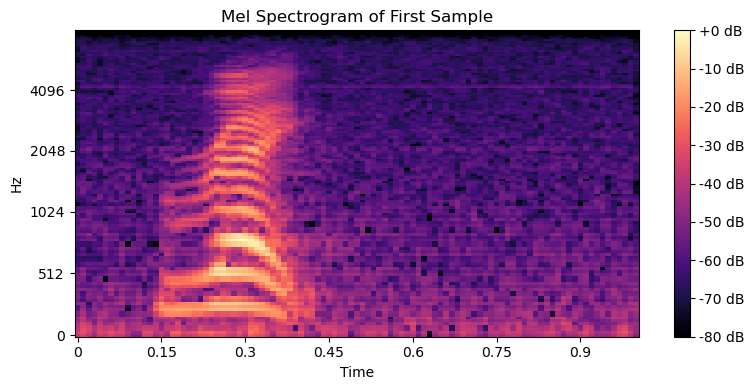

In [5]:
import matplotlib.pyplot as plt
import librosa.display

# Assuming your spectrogram matrix is named 'spectrogram'
first_sample = X_train[0]  # Shape: (128, 99)

plt.figure(figsize=(8, 4))
librosa.display.specshow(first_sample, 
                         x_axis='time', 
                         y_axis='mel', 
                         sr=16000,  # Adjust this to your actual sample rate
                         hop_length=160)  # Adjust this to your actual hop length
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of First Sample')
plt.tight_layout()

plt.savefig('spectrogram_first_sample.png', dpi=300, bbox_inches='tight')

plt.show()


In [7]:
clf = RocketClassifier(random_state=42,num_kernels=100000)

In [8]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

RocketClassifier(num_kernels=100000, random_state=42)

In [9]:
param = clf.pipeline_[-1]  

# Counting the number of parameters (coef_ and intercept_)
n_params = param.coef_.size + param.intercept_.size
print(f"Number of parameters: {n_params}")

Number of parameters: 2400012


In [10]:
# Predict on the test set
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.944574833002347


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.9442836715357595
Recall (macro): 0.9449427138224809
F1 Score (macro): 0.9443073240206369


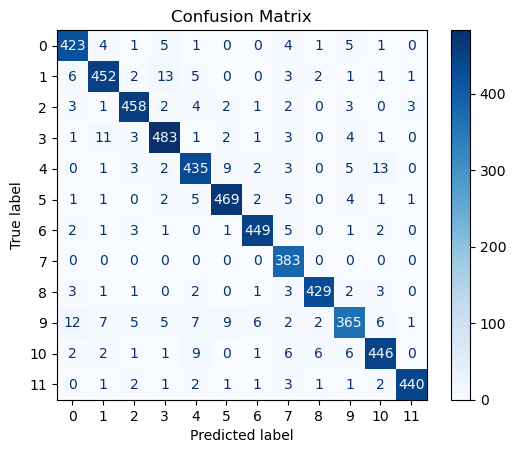

In [12]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




In [13]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=labels))
# Map for labels
print("Label mapping:", {idx: label for label, idx in enumerate(labels)})

Classification Report:
               precision    recall  f1-score   support

        down       0.93      0.95      0.94       445
          go       0.94      0.93      0.93       486
        left       0.96      0.96      0.96       479
          no       0.94      0.95      0.94       510
         off       0.92      0.92      0.92       473
          on       0.95      0.96      0.95       491
       right       0.97      0.97      0.97       465
     silence       0.91      1.00      0.95       383
        stop       0.97      0.96      0.97       445
     unknown       0.92      0.85      0.89       427
          up       0.94      0.93      0.93       480
         yes       0.99      0.97      0.98       455

    accuracy                           0.94      5539
   macro avg       0.94      0.94      0.94      5539
weighted avg       0.94      0.94      0.94      5539

Label mapping: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'silence': 7, 'stop': 

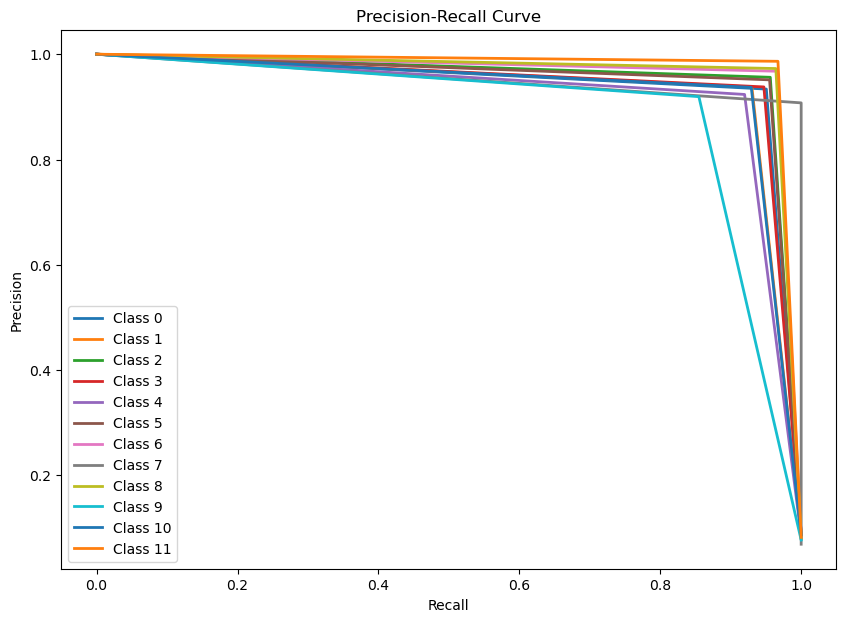

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Example: Define y_test and y_pred
# Replace these with your actual labels
# y_test = [0, 1, 2, 0, 1, 2]  # True labels
# y_pred = [0, 2, 1, 0, 0, 1]  # Predicted labels

# Get the unique classes and binarize labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

n_classes = y_test_bin.shape[1]

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


In [15]:
print(X[0][0].shape)

(101,)


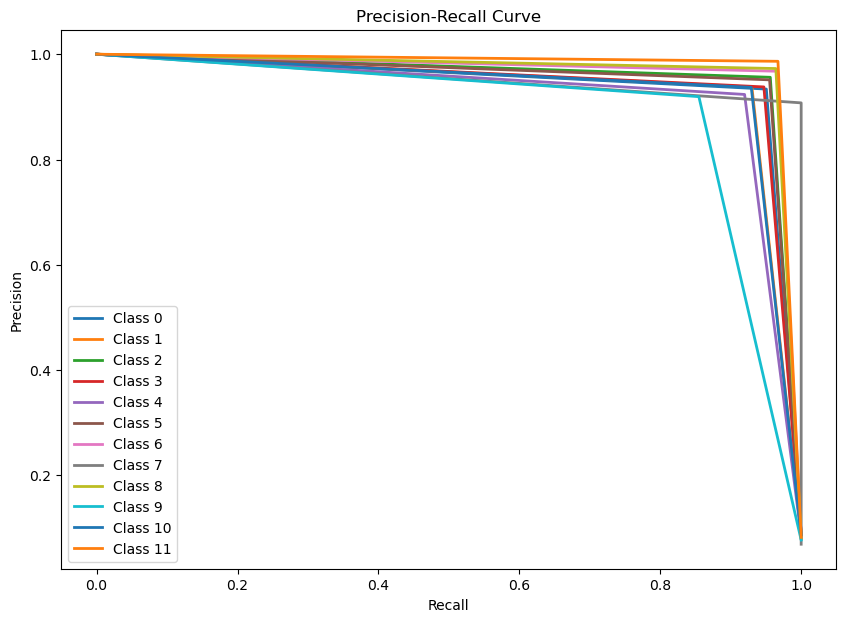

In [16]:
# Get predicted probabilities using the predict_proba() method
y_pred_prob = clf.predict_proba(X_test)

# Binarize the true labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

n_classes = 12

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    # Get precision and recall for each class using the predicted probabilities
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


In [17]:
print(y_pred_prob)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


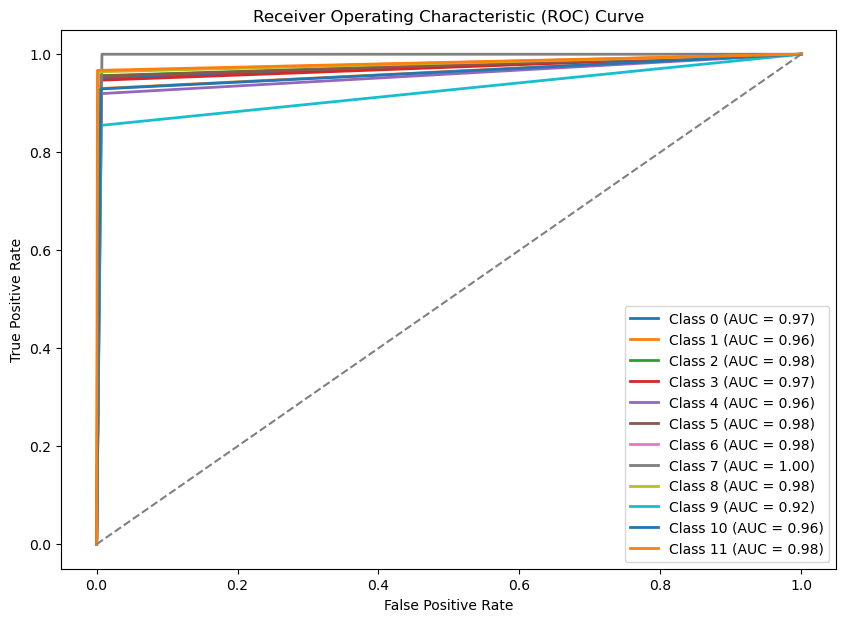

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris




# Plot ROC Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    # Get ROC curve metrics for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)  # Compute AUC for each class
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random classifier (AUC = 0.5)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Plot details
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")
plt.show()


In [19]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = clf.predict(X_test)

# Print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       445
           1       0.94      0.93      0.93       486
           2       0.96      0.96      0.96       479
           3       0.94      0.95      0.94       510
           4       0.92      0.92      0.92       473
           5       0.95      0.96      0.95       491
           6       0.97      0.97      0.97       465
           7       0.91      1.00      0.95       383
           8       0.97      0.96      0.97       445
           9       0.92      0.85      0.89       427
          10       0.94      0.93      0.93       480
          11       0.99      0.97      0.98       455

    accuracy                           0.94      5539
   macro avg       0.94      0.94      0.94      5539
weighted avg       0.94      0.94      0.94      5539

